In [4]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder

import plotly.express as px
import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = 'jupyterlab'

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data

from functions import *
from DrawTree import DrawTree

In [5]:
df = load_data()
df.head()

customerID  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0  7590-VHVEG              0        1           0       1             0   
1  5575-GNVDE              0        0           0      34             1   
2  3668-QPYBK              0        0           0       2             1   
3  7795-CFOCW              0        0           0      45             0   
4  9237-HQITU              0        0           0       2             1   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0                1               0             1                 0  ...   
1                1               1             0                 1  ...   
2                1               1             1                 0  ...   
3                1               1             0                 1  ...   
4                1               0             0                 0  ...   

   Churn  Phone Lines  One year  Two year  Credit card (automatic)  \
0      0            0         0         0                        0   
1      0            1         1         0                        0   
2      1            1         0         0                        0   
3      0            0         1         0                        0   
4      1            1         0         0                        0   

   Electronic check  Mailed check  Male  DSL  Fiber optic  
0                 1             0     0    1            0  
1                 0             1     1    1            0  
2                 0             1     1    1            0  
3                 0             0     1    1            0  
4                 1             0     0    0            1  

[5 rows x 26 columns]

### Predicting Customer Churn with a Decision Tree

In [6]:
from sklearn.model_selection import StratifiedKFold,train_test_split

X = df.drop(columns=['Churn','customerID','TotalCharges'])
Y = df['Churn']

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.2,stratify=df[['One year','Two year','Churn']])


num_features = ['MonthlyCharges']
ord_features = ['tenure']

from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

decision_tree = DecisionTreeClassifier(max_depth=4)

sm_pipeline = make_pipeline(
                            SMOTE(n_jobs=-1,random_state=43),
                            decision_tree
                           )

fit = sm_pipeline.fit(X_train,y_train)

y_pred = fit.predict(X_test)

from sklearn.metrics import classification_report
from sklearn import metrics

pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

Using TensorFlow backend.


0           1  accuracy    macro avg  weighted avg
precision     0.874207    0.550756  0.767921     0.712482      0.788351
recall        0.799034    0.681818  0.767921     0.740426      0.767921
f1-score      0.834932    0.609319  0.767921     0.722125      0.775046
support    1035.000000  374.000000  0.767921  1409.000000   1409.000000

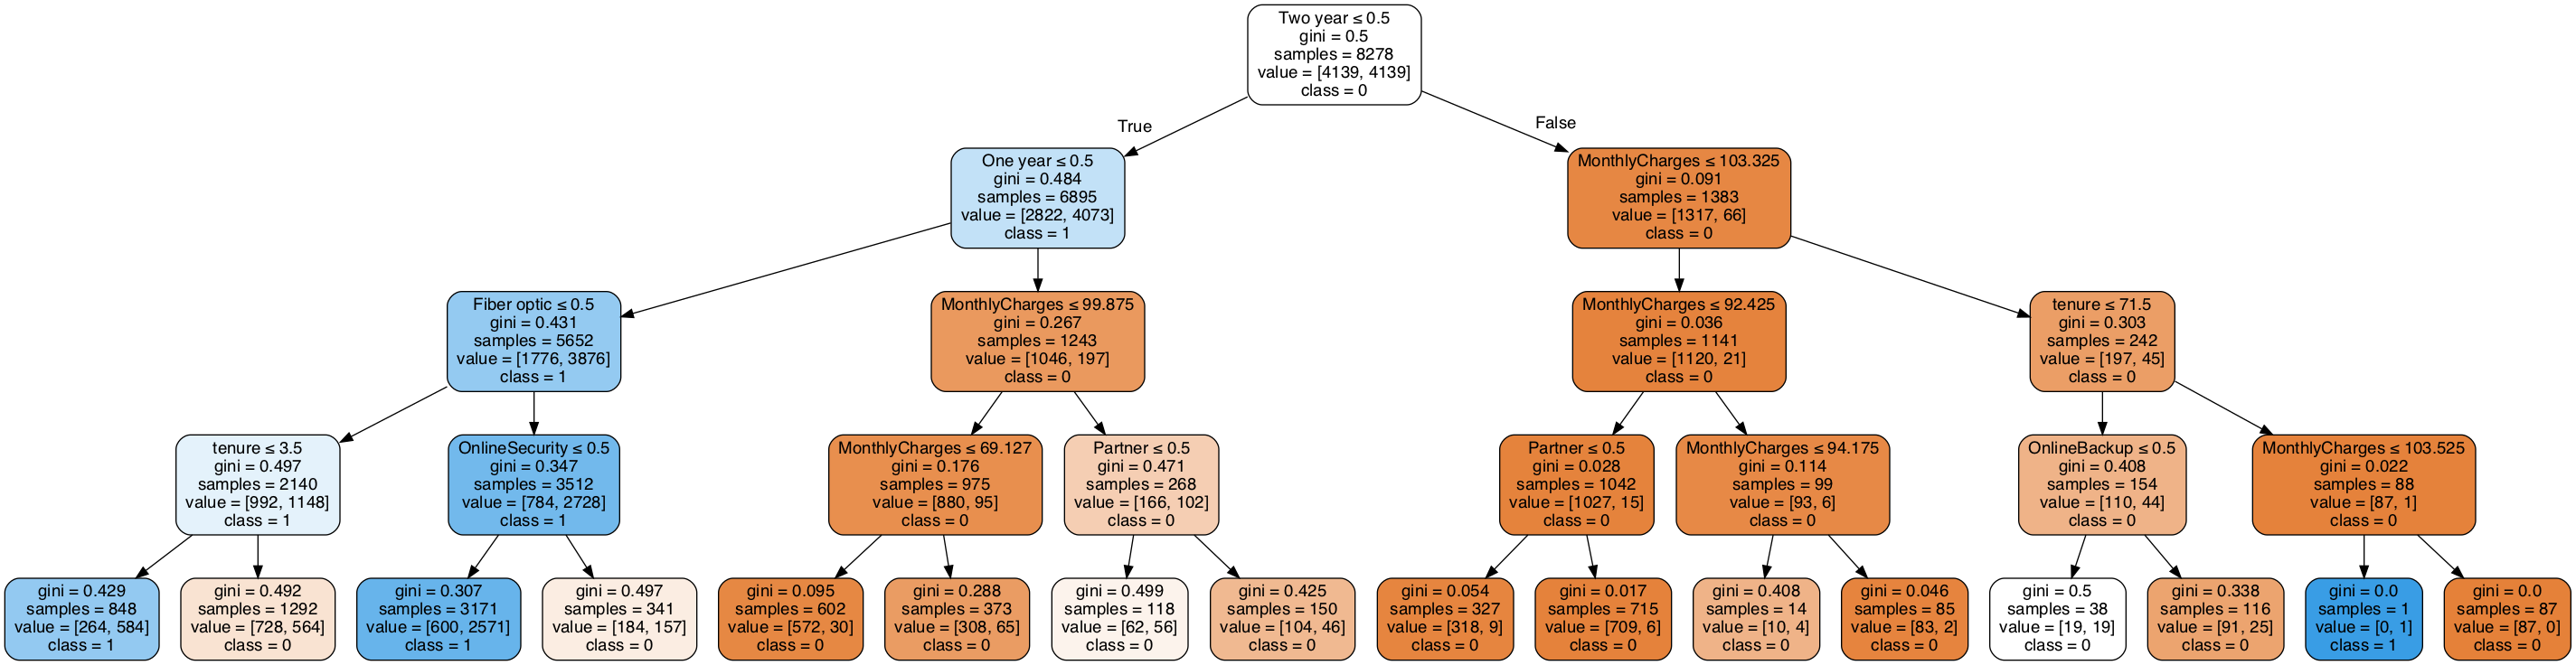

In [7]:
plot_tree(decision_tree,X_train,y_train)

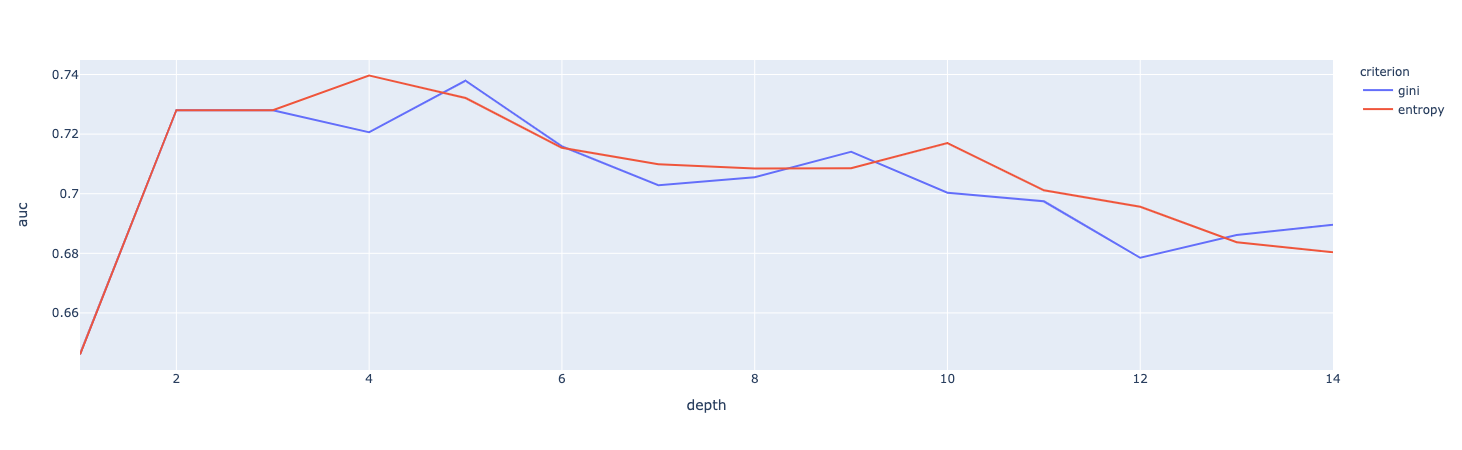

In [66]:
results = []
for i in range(1,15):
    for crit in ['gini','entropy']:
        decision_tree = DecisionTreeClassifier(max_depth=i,criterion=crit,max_features=None)

        sm_pipeline = make_pipeline(
                                    SMOTE(n_jobs=-1,random_state=43),
                                    decision_tree
                                   )

        fit = sm_pipeline.fit(X_train,y_train)

        y_pred = fit.predict(X_test)

        recall = metrics.recall_score(y_test,y_pred,pos_label=1)
        precision = metrics.precision_score(y_test,y_pred,pos_label=1)
        auc = metrics.roc_auc_score(y_test,y_pred,average='micro')
    
        results.append({'depth':i,'recall':recall,'precision':precision,'auc':auc,'criterion':crit})
tree_performance = pd.DataFrame.from_records(results)
px.line(data_frame=tree_performance,x='depth',y='auc',color='criterion')

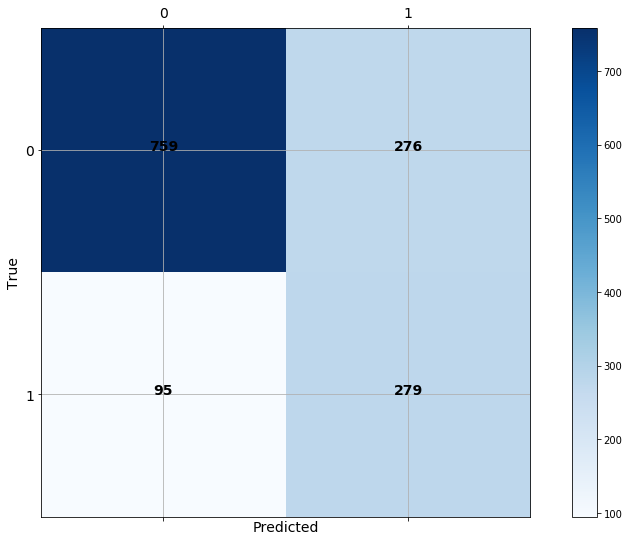

In [67]:
decision_tree = DecisionTreeClassifier(max_depth=4,criterion='entropy')

sm_pipeline = make_pipeline(
                            SMOTE(n_jobs=-1,random_state=43),
                            decision_tree
                           )

fit = sm_pipeline.fit(X_train,y_train)

y_pred = fit.predict(X_test)

plot_confusion_matrix(y_test,y_pred,classes=[0,1])

### Plotting Decision Tree with Plotly

In [11]:
tree = decision_tree.tree_
n_nodes = tree.node_count
children_left = tree.children_left
children_right = tree.children_right
feature = tree.feature
threshold = tree.threshold

In [15]:
class Tree():
    def __init__(self,estimator):
        tr = estimator.tree_
        n_nodes = tr.node_count
        children_left = tr.children_left
        children_right = tr.children_right
        
        self.children = list(zip(children_left,children_right))
            

In [17]:
tree = Tree(decision_tree)

In [20]:
tree.children

[(1, 16),
 (2, 9),
 (3, 6),
 (4, 5),
 (-1, -1),
 (-1, -1),
 (7, 8),
 (-1, -1),
 (-1, -1),
 (10, 13),
 (11, 12),
 (-1, -1),
 (-1, -1),
 (14, 15),
 (-1, -1),
 (-1, -1),
 (17, 24),
 (18, 21),
 (19, 20),
 (-1, -1),
 (-1, -1),
 (22, 23),
 (-1, -1),
 (-1, -1),
 (25, 28),
 (26, 27),
 (-1, -1),
 (-1, -1),
 (29, 30),
 (-1, -1),
 (-1, -1)]

In [19]:
DrawTree(tree)

AttributeError: 'tuple' object has no attribute 'children'

In [9]:
node_depth = np.zeros(shape=n_nodes,dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes,dtype=bool)
stack = [(0,-1)]
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1
    
    # If we have a test node 
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

[]

In [128]:
def make_line(node_id,child_list,line=[]):
    if child_list[node_id] == -1:
        return line
    else:
        line.append(child_list[node_id])
        return make_line(child_list[node_id],child_list,line=line)

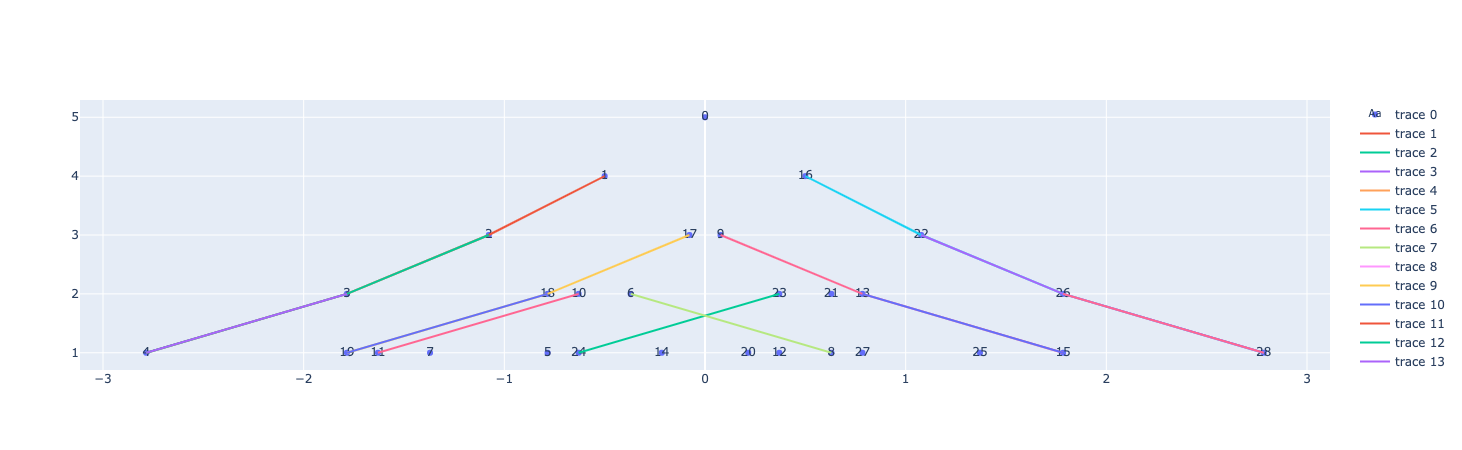

In [151]:
def plotly_decisionTree(estimator):
    tree = estimator.tree_
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    node_depth = np.zeros(shape=n_nodes,dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes,dtype=bool)
    stack = [(0,-1)]
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node 
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    node_structure = {}
    node_heights = [np.abs(x-np.max(node_depth)) for x in node_depth]
    for node_id in range(n_nodes):
        node_dict = {
            'height':node_heights[node_id]+1
        }
        if node_id == 0: # if it's the first parent node
            node_dict['x_position'] = 0
        else:
            #find parent node
            if node_id in children_left:
                parent_id = children_left.tolist().index(node_id)
                parent_node = node_structure[parent_id]
            if node_id in children_right:
                parent_id = children_right.tolist().index(node_id)
                parent_node = node_structure[parent_id]
            
            # set x position of node based on parent node 
            if node_id == parent_node['children'][0]:
                node_dict['x_position'] = parent_node['x_position'] - np.sqrt((1/node_dict['height']))
            elif node_id == parent_node['children'][1]:
                node_dict['x_position'] = parent_node['x_position'] + np.sqrt((1/node_dict['height']))
            else:
                node_dict['x_position'] = parent_node['x_position']

        node_dict['children'] = (children_left[node_id],children_right[node_id])
        node_dict['children_left'] = children_left[node_id]
        node_dict['children_right'] = children_right[node_id]

        node_structure[node_id]=node_dict

    structure = pd.DataFrame(node_structure).T
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=structure['x_position'],
        y=structure['height'],
        mode='markers+text',
        text=structure.index
    ))
    for child_list in children_left,children_right:
        L = []
        for n in range(nodes):
            temp = make_line(n,child_list,line=[]) 
            if temp == []:
                continue 
            else:
                L.append(temp)

        for l in L:
            _line = [(node_structure[x]['x_position'],node_structure[x]['height']) for x in l]
            fig.add_trace(
                go.Scatter(
                    x=[p[0] for p in _line],
                    y=[p[1] for p in _line],
                    mode = 'lines',
                )
            )
    return fig
    
fig = plotly_decisionTree(decision_tree)
fig.show()

In [123]:
L = []
for n in range(nodes):
    temp = make_line(n,children_right,line=[]) 
    if temp == []:
        break
    else:
        L.append(temp)

In [124]:
L

[[16, 22, 26, 28], [9, 13, 15], [6, 8], [5]]

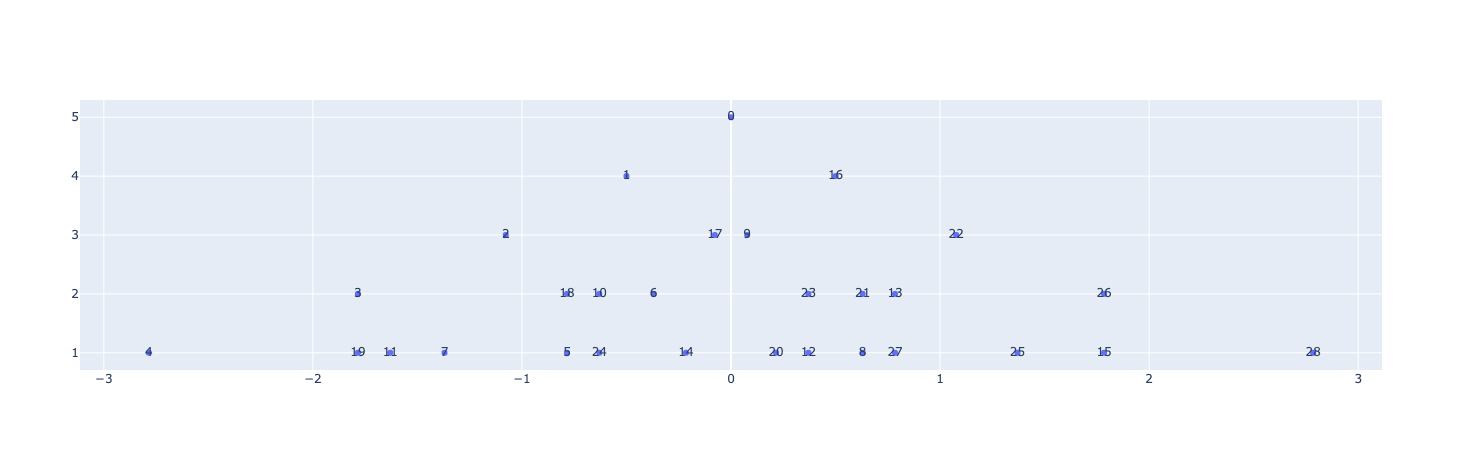

In [91]:
fig.add_trace()

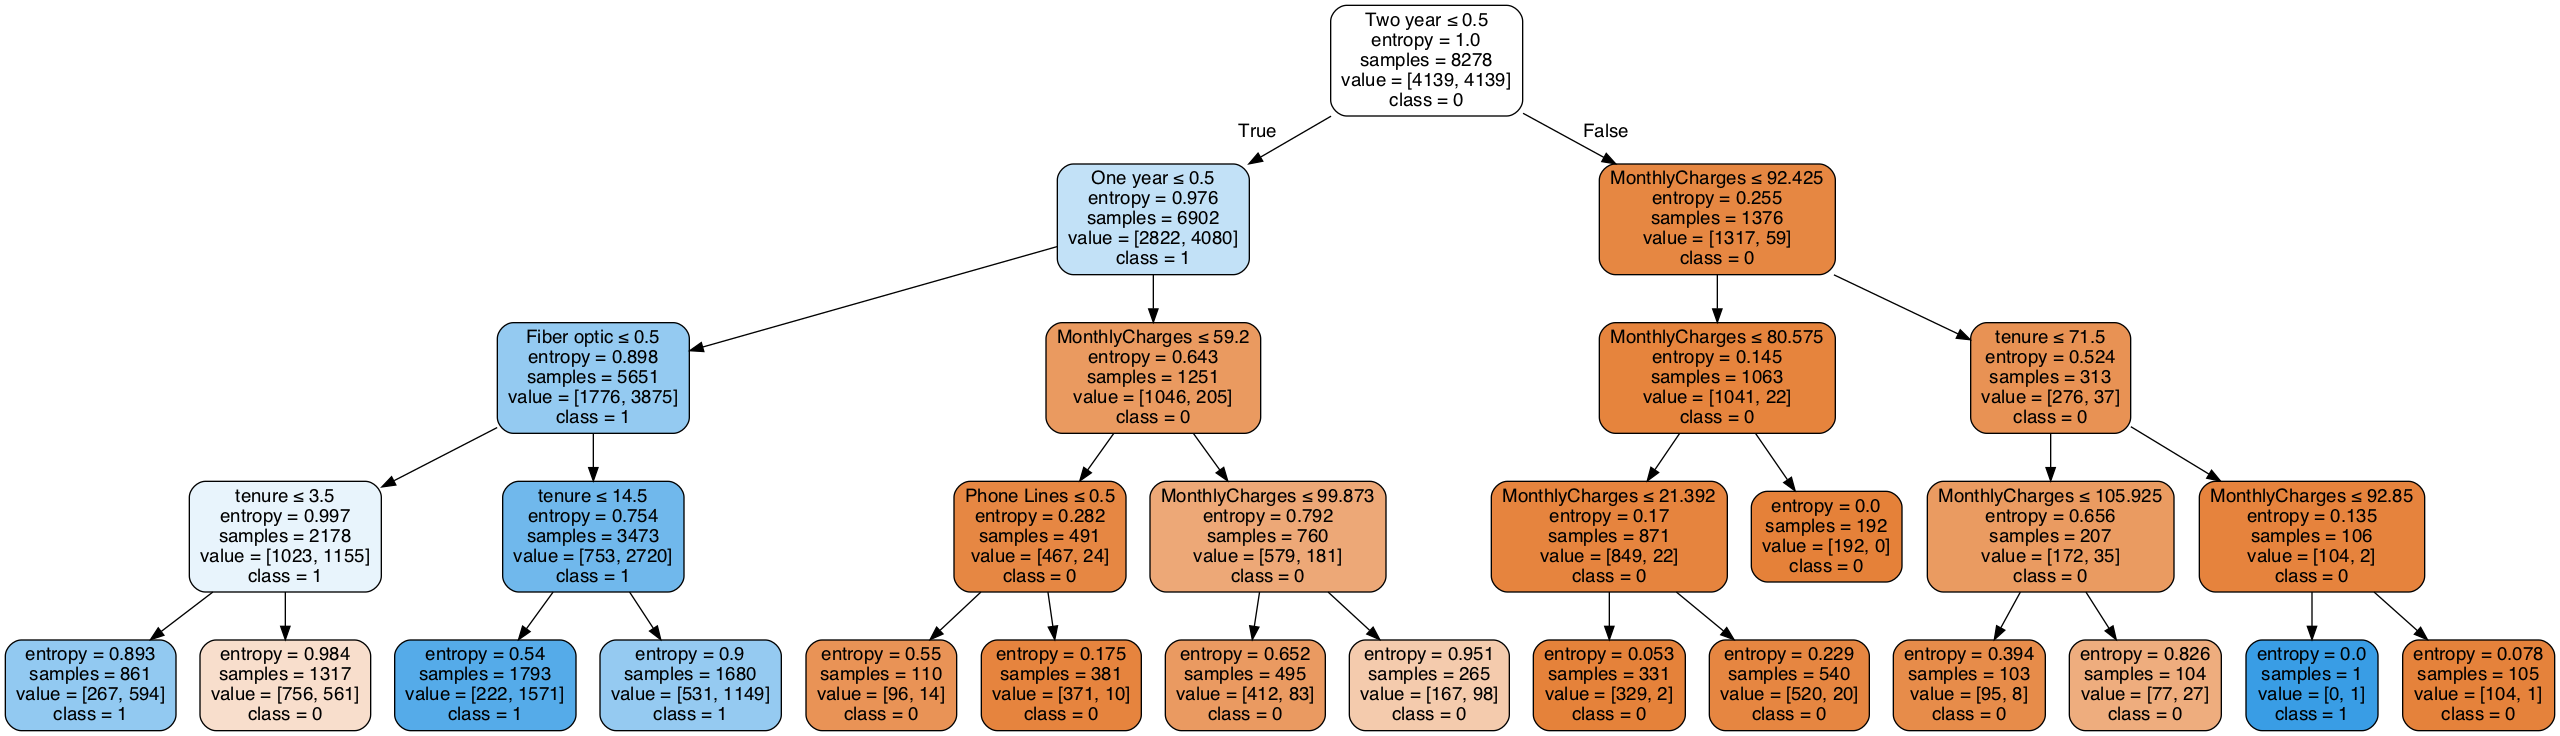

In [77]:
plot_tree(decision_tree,X_train,y_train)

### Customer Lifetime Value

We can only look at CLTV for those who have already churned. 

Here is the formula for Customer Lifetime Value:

![CLV formula](images/CLV_formula.png)

ARPA equals the average revenue per account for a period of time (e.g. monthly)

In [33]:
X = df.drop(columns=['Churn','customerID','TotalCharges','tenure'])
Y = df['Churn']

In [34]:
leaves_mse = []
for num_leaves in range(2,12):
    for crit in ['gini','entropy']:
        mse_list = []
        for n in range(0,10):
            
            churn_tree = DecisionTreeClassifier(max_leaf_nodes=num_leaves,criterion=crit)

            sm_pipeline = make_pipeline(
                                        SMOTE(n_jobs=-1,random_state=43),
                                        churn_tree
                                       )
            X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.2,stratify=df[['One year','Two year','Churn']])

            fit = sm_pipeline.fit(X_train,y_train)

            test_data = X_test.copy()
            test_data['leaf']=churn_tree.apply(test_data)

            i = X_test.index
            test_data = test_data.join(df.loc[i][['TotalCharges','Churn']])
            test_data.replace(' ',np.nan,inplace=True)
            test_data['TotalCharges']=test_data['TotalCharges'].astype(float)

            actual_clv = test_data[test_data['Churn']==1].groupby('leaf')[['TotalCharges']].mean()

            predicted_clv = test_data.groupby('leaf')[['MonthlyCharges','Churn']].mean()

            predicted = pd.DataFrame(1/predicted_clv['Churn']*predicted_clv['MonthlyCharges'],columns=['Predicted CLV'])
            result = predicted.join(actual_clv)
            mse = metrics.mean_squared_error(result['TotalCharges'],result['Predicted CLV'])

            mse_list.append(mse)

        leaves_mse.append({'leaves':num_leaves,'mse':np.mean(mse_list),'std':np.std(mse_list),'criterion':crit})

mse_df = pd.DataFrame.from_records(leaves_mse)
mse_df.sort_values('mse',ascending=True)

leaves           mse           std criterion
16      10  4.941443e+06  9.144753e+05      gini
17      10  4.942702e+06  1.018162e+06   entropy
18      11  4.951400e+06  4.366905e+05      gini
19      11  5.271153e+06  8.906642e+05   entropy
11       7  5.489324e+06  6.950207e+05   entropy
14       9  5.629462e+06  9.676279e+05      gini
6        5  5.630540e+06  6.951194e+05      gini
15       9  5.688934e+06  9.088967e+05   entropy
13       8  5.901518e+06  1.481114e+06   entropy
7        5  6.016358e+06  1.132645e+06   entropy
8        6  6.208024e+06  2.244083e+06      gini
4        4  6.307625e+06  1.420129e+06      gini
12       8  6.396783e+06  5.777015e+05      gini
5        4  6.551199e+06  9.532587e+05   entropy
0        2  6.733267e+06  1.845288e+06      gini
10       7  6.798413e+06  1.401778e+06      gini
3        3  7.803971e+06  1.417544e+06   entropy
9        6  7.815082e+06  1.329731e+06   entropy
1        2  7.835778e+06  1.687005e+06   entropy
2        3  8.414225e+06  1.217871e+06      gini

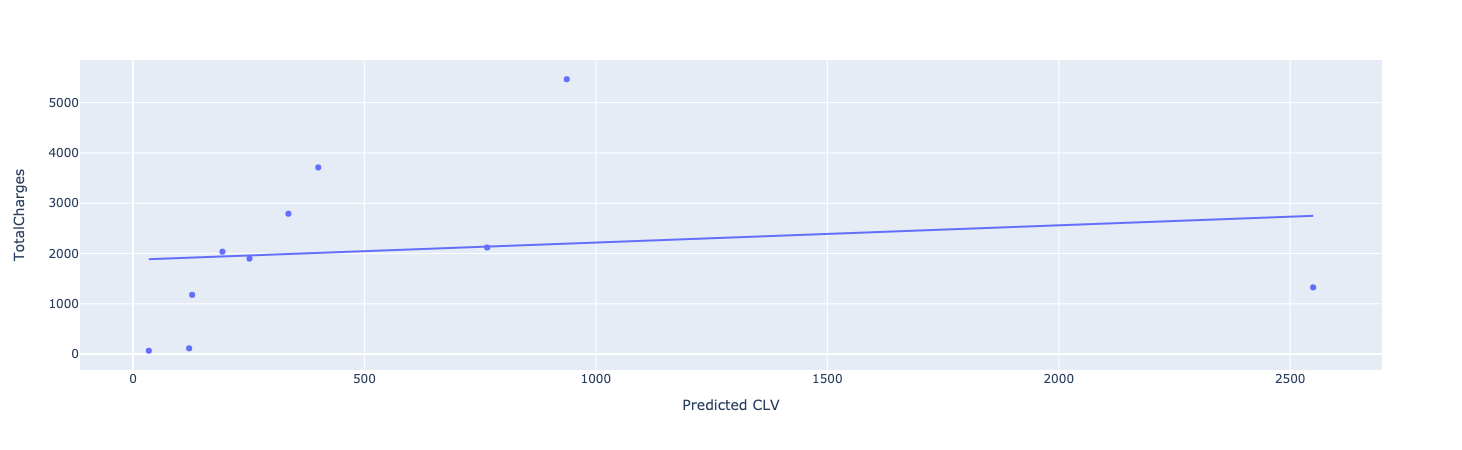

In [35]:
churn_tree = DecisionTreeClassifier(max_features='sqrt',max_leaf_nodes=10,criterion='gini')

sm_pipeline = make_pipeline(
                            SMOTE(n_jobs=-1,random_state=43),
                            churn_tree
                           )
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.2,stratify=df['Churn'])

fit = sm_pipeline.fit(X_train,y_train)

test_data = X_test.copy()
test_data['leaf']=churn_tree.apply(test_data)

i = X_test.index
test_data = test_data.join(df.loc[i][['TotalCharges','Churn']])
test_data.replace(' ',np.nan,inplace=True)
test_data['TotalCharges']=test_data['TotalCharges'].astype(float)

actual_clv = test_data[test_data['Churn']==1].groupby('leaf')[['TotalCharges']].mean()

predicted_clv = test_data.groupby('leaf')[['MonthlyCharges','Churn']].mean()

predicted = pd.DataFrame((1/predicted_clv['Churn'])*predicted_clv['MonthlyCharges'],columns=['Predicted CLV'])
result = predicted.join(actual_clv)

result.reset_index(inplace=True)
px.scatter(result,x='Predicted CLV',y='TotalCharges',trendline='ols')


In [36]:
result

leaf  Predicted CLV  TotalCharges
0     5     251.683824   1899.532353
1     6     765.203125   2120.164063
2     8     335.774074   2791.455556
3    10     400.350000   3712.071429
4    12     937.100000   5464.650000
5    13     127.821127   1178.007042
6    14     193.280435   2036.743478
7    16      34.306250     66.868750
8    17     121.340323    115.585484
9    18    2549.600000   1327.150000

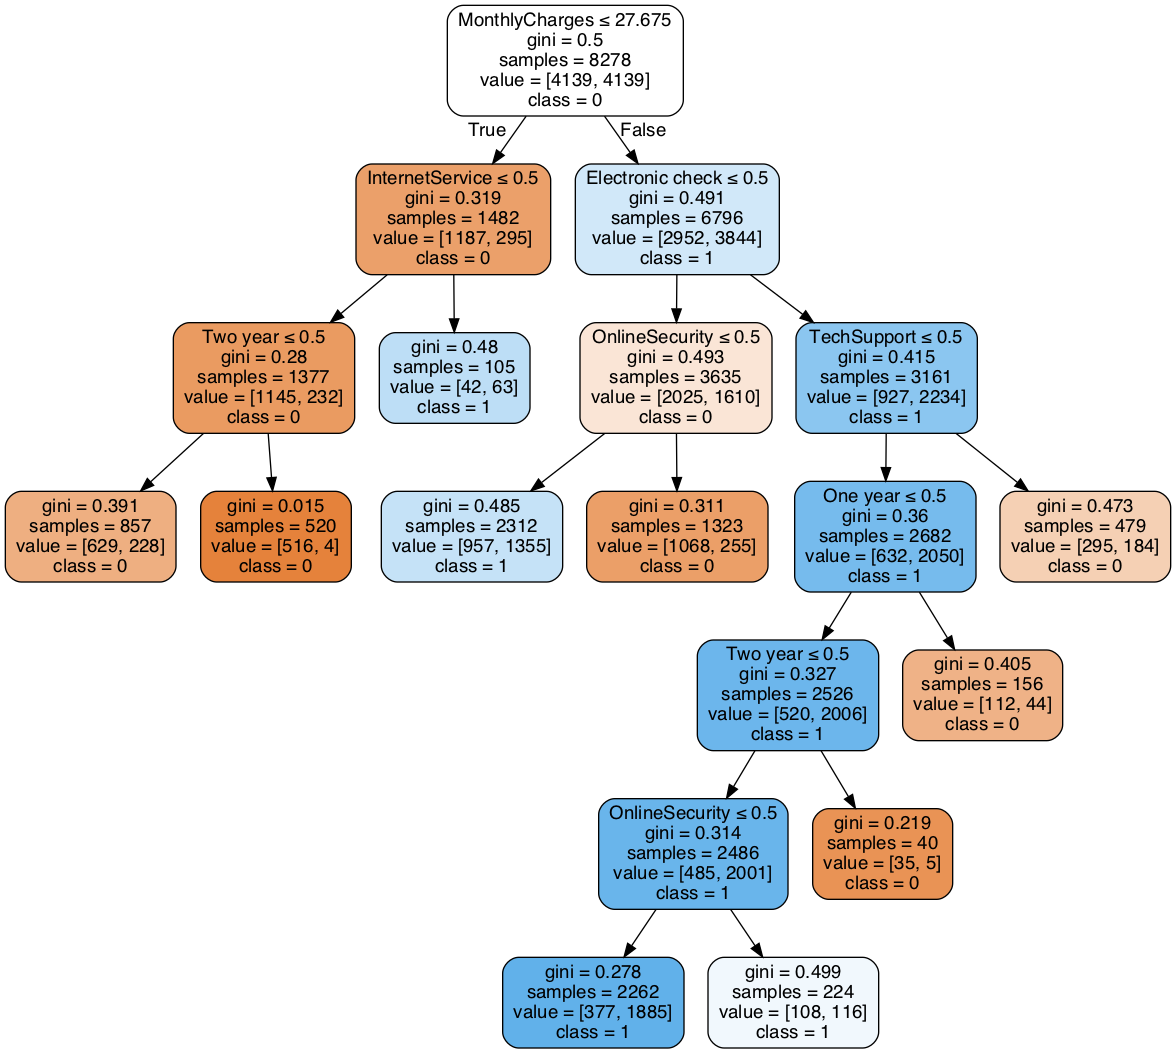

In [37]:
plot_tree(churn_tree,X_train,y_train)

In [38]:
tree = churn_tree.tree_
n_nodes = tree.node_count
children_left = tree.children_left
children_right = tree.children_right
feature = tree.feature
threshold = tree.threshold

node_depth = np.zeros(shape=n_nodes,dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes,dtype=bool)
stack = [(0,-1)]
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1
    
    # If we have a test node 
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

In [53]:
node_structure = {}
node_heights = [np.abs(x-np.max(node_depth)) for x in node_depth]
for node_id in range(n_nodes):
    node_dict = {
        'height':node_heights[node_id]
    }
    if node_id == 0: # if it's the parent node
        node_dict['x_position'] = 0
    else:
        #find parent node
        if node_id in children_left:
            parent_id = children_left.tolist().index(node_id)
            parent_node = node_structure[parent_id]
        if node_id in children_right:
            parent_id = children_right.tolist().index(node_id)
            parent_node = node_structure[parent_id]
        if node_id == parent_node['children'][0]:
            node_dict['x_position'] = parent_node['x_position'] - (1/(node_id+.99))
        elif node_id == parent_node['children'][1]:
            node_dict['x_position'] = parent_node['x_position'] + (1/node_id) 
        else:
            node_dict['x_position'] = parent_node['x_position']
        
    node_dict['children'] = (children_left[node_id],children_right[node_id])
    node_dict['children_left'] = children_left[node_id]
    node_dict['children_right'] = children_right[node_id]
    
    node_structure[node_id]=node_dict

structure = pd.DataFrame(node_structure).T
structure

height x_position  children children_left children_right
0       6          0    (1, 2)             1              2
1       5  -0.502513  (15, 16)            15             16
2       5        0.5    (3, 4)             3              4
3       4   0.249373    (5, 6)             5              6
4       4       0.75    (7, 8)             7              8
5       3  0.0824285  (-1, -1)            -1             -1
6       3    0.41604  (-1, -1)            -1             -1
7       3   0.624844   (9, 10)             9             10
8       3      0.875  (-1, -1)            -1             -1
9       2   0.524743  (11, 12)            11             12
10      2   0.724844  (-1, -1)            -1             -1
11      1   0.441341  (13, 14)            13             14
12      1   0.608077  (-1, -1)            -1             -1
13      0   0.369861  (-1, -1)            -1             -1
14      0   0.512769  (-1, -1)            -1             -1
15      4  -0.565052  (17, 18)            17             18
16      4  -0.440013  (-1, -1)            -1             -1
17      3  -0.620638  (-1, -1)            -1             -1
18      3  -0.509496  (-1, -1)            -1             -1

In [46]:
# makes the lines 
lines = []
for child_list in [children_left,children_right]:
    for node_id in range(n_nodes):
        if child_list[node_id] == -1:
            continue 
        else:
            line = []
            child_list[node_id]
        

In [47]:
def make_line(node_id,child_list,line=[]):
    if child_list[node_id] == -1:
        return line
    else:
        line.append(child_list[node_id])
        return make_line(child_list[node_id],child_list,line=line)

In [48]:
make_line(0,children_right,line=[])

[2, 4, 8]

In [49]:
[make_line(x,children_left) for x in range(n_nodes)]

[[1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 13, 17],
 [1, 15, 17, 15, 17, 3, 5, 5, 7, 9, 11, 13, 9, 11, 13, 11, 13, 1

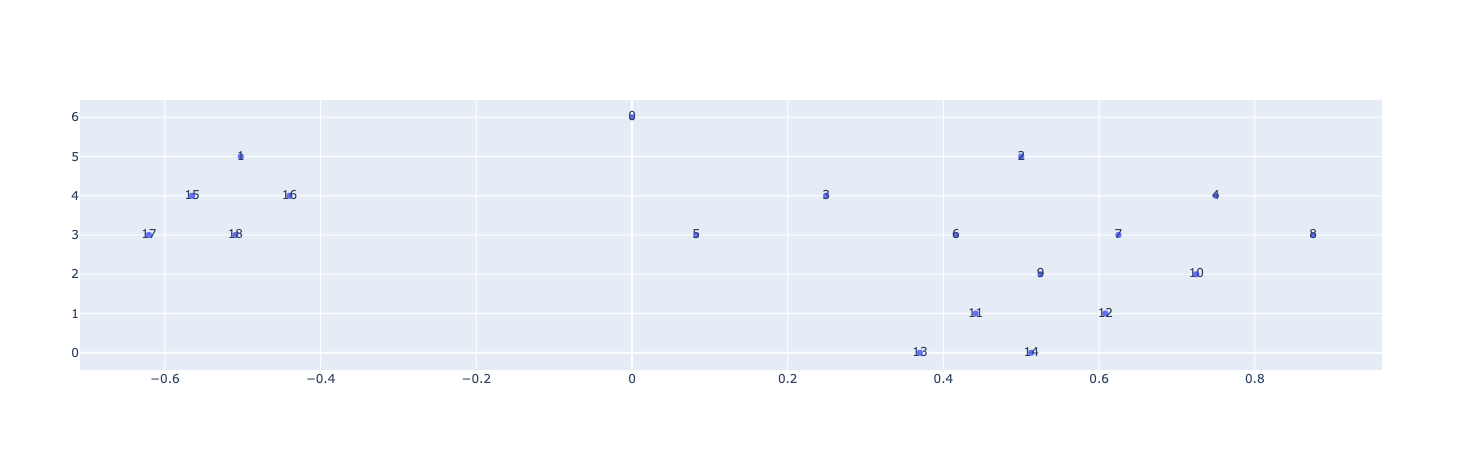

In [50]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=structure['x_position'],
    y=structure['height'],
    mode='markers+text',
    text=structure.index
))
fig.add_trace(go.Scatter())
fig.show()

In [36]:
pos = {node_id: [node_structure[node_id]['x_position'],node_structure[node_id]['height']] for node_id in range(n_nodes)}
pos

{0: [0, 5],
 1: [-0.5025125628140703, 4],
 2: [0.5, 4],
 3: [-0.7531391292301104, 3],
 4: [-0.2525125628140703, 3],
 5: [-0.9200840374104109, 2],
 6: [-0.5864724625634438, 2],
 7: [-0.37766900837101647, 2],
 8: [-0.1275125628140703, 2],
 9: [-0.6865725626635438, 1],
 10: [-0.4864724625634438, 1],
 11: [-0.7699753983599575, 0],
 12: [-0.6032392293302105, 0],
 13: [0.4285203716940672, 3],
 14: [0.5714285714285714, 3],
 15: [0.36598128476473635, 2],
 16: [0.4910203716940672, 2],
 17: [0.43543393478467307, 1],
 18: [0.5465759272496228, 1]}

In [37]:
layout = [(x,sum(node_depth==x)) for x in node_depth]

In [38]:
layout

[(0, 1),
 (1, 2),
 (1, 2),
 (2, 4),
 (2, 4),
 (3, 6),
 (3, 6),
 (3, 6),
 (3, 6),
 (4, 4),
 (4, 4),
 (5, 2),
 (5, 2),
 (2, 4),
 (2, 4),
 (3, 6),
 (3, 6),
 (4, 4),
 (4, 4)]

In [27]:
import igraph
from igraph import Graph,EdgeSeq

In [ ]:
Graph.Tree()

In [30]:
nr_verticies = decision_tree.tree_.node_count
v_label = list(map(str,range(nr_verticies)))
G = Graph.Tree(nr_verticies,2,) # 2 stands for children (true/false)
lay = G.layout('tree')
position = {k: lay[k] for k in range(nr_verticies)}
#position = pos
Y = [lay[k][1] for k in range(nr_verticies)]

es = EdgeSeq(G) # sequence of edges
E = [e.tuple for e in G.es] # list of edges
M = max(Y)

L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [2*M-position[k][1] for k in range(L)]
Xe = []
Ye = []
for edge in E:
    Xe+=[position[edge[0]][0],position[edge[1]][0],None]
    Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None]
    
labels = v_label

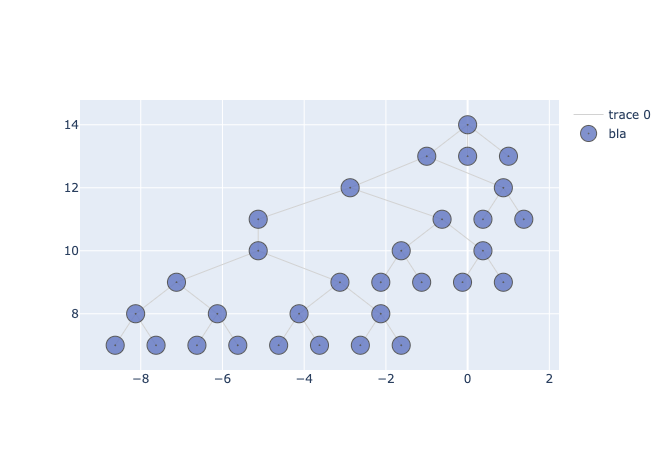

In [31]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))
fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=18,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

In [65]:
dot_data = export_graphviz(decision_tree, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=np.unique(y_train).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

graph = graph_from_dot_data(dot_data)

edges = graph.get_edge_list()